Biagio Buono - 5206214 <br>
Leonardo Puricelli - 5214494

# **Deep Learning Project**

In this paper, we present the implementation of a slightly adapted version of the AlexNet model for image classification tasks. <br>
Our application of the model extends across two distinct datasets:

- Intel Image Classification, that we consider in the current notebook and can be downloaded at the following link: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/download?datasetVersionNumber=2
- Plant Disease Recognition, employed in the second notebook and available here: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/download?datasetVersionNumber=1

Before getting into details, we import the necessary libraries and link the drive to access the datasets.



In [ ]:
%%capture
pip install d2l==1.0.0a1.post0

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import random
from PIL import Image
import torchvision
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch.utils.data import DataLoader
from d2l import torch as d2l
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


# Intel Image Classification Dataset

The Image Classification dataset is retrieved from Kaggle (https://www.kaggle.com/datasets/puneet6060/intel-image-classification) and contains about 25k RGB images of natural scenes around the world distributed under six categories:

- buildings
- forest
- glacier
- mountain
- sea
- street

An RGB image is a matrix of pixel values having three planes, where each pixel is defined by three values corresponding to the intensity of red, green and blue light. Here is a graphical explanation:

![](https://editor.analyticsvidhya.com/uploads/306461_15yDvGKV47a0nkf5qLKOOQ.png)

Data are separated into Train, Test and Predictions sets, but we take into consideration only the first two, since the last one does not provide the category associated with each image and we are implementing supervised learning algorithms. <br>
For this reason, the ultimate dataset is approximately made by 17k images (14k in the Train set and 3k in the Test one).

## Load the dataset

First, we unzip the file containing the dataset in our environment and set up the directories for each category in both the considered sets.

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/landscape_zippato.zip'

In [ ]:
train_directories = [
    '/content/seg_train/seg_train/buildings',
    '/content/seg_train/seg_train/forest',
    '/content/seg_train/seg_train/glacier',
    '/content/seg_train/seg_train/mountain',
    '/content/seg_train/seg_train/sea',
    '/content/seg_train/seg_train/street',
]

test_directories = [
    '/content/seg_test/seg_test/buildings',
    '/content/seg_test/seg_test/forest',
    '/content/seg_test/seg_test/glacier',
    '/content/seg_test/seg_test/mountain',
    '/content/seg_test/seg_test/sea',
    '/content/seg_test/seg_test/street',
]

Check for the number of images in each class in the Train and Test sets:

In [ ]:
for directory_path in train_directories:

    category_name = os.path.basename(directory_path)
    images_count = len(os.listdir(directory_path))

    print(f"Category: {category_name:<10} - Number of images: {images_count}")

Category: buildings  - Number of images: 2191
Category: forest     - Number of images: 2271
Category: glacier    - Number of images: 2404
Category: mountain   - Number of images: 2512
Category: sea        - Number of images: 2274
Category: street     - Number of images: 2382


In [ ]:
for directory_path in test_directories:

    category_name = os.path.basename(directory_path)
    images_count = len(os.listdir(directory_path))

    print(f"Category: {category_name:<10} - Number of images: {images_count}")

Category: buildings  - Number of images: 437
Category: forest     - Number of images: 474
Category: glacier    - Number of images: 553
Category: mountain   - Number of images: 525
Category: sea        - Number of images: 510
Category: street     - Number of images: 501


## Create validation dataset

In this section, we build the Validation set by transferring 20% of images (randomly chosen) from each class in the training set to the newly created categories within the validation set.

In [ ]:
validation_directories = [
    '/content/seg_train/seg_val/buildings',
    '/content/seg_train/seg_val/forest',
    '/content/seg_train/seg_val/glacier',
    '/content/seg_train/seg_val/mountain',
    '/content/seg_train/seg_val/sea',
    '/content/seg_train/seg_val/street',
]

In [ ]:
validation_split = 0.2

for train_dir, val_dir in zip(train_directories, validation_directories):
    files = os.listdir(train_dir) # Get the list of files in the current training directory

    train_files, val_files = train_test_split(files, test_size=validation_split, random_state=22)
    os.makedirs(val_dir, exist_ok=True) # Create the validation directory if it doesn't exist

    for file in val_files:
        src_path = os.path.join(train_dir, file) # source path in the training directory
        dest_path = os.path.join(val_dir, file)  # destination path in the validation directory
        shutil.move(src_path, dest_path)         # move the file from training to validation

Then check for the number of images in each class in both the Validation and Train sets:

In [ ]:
for directory_path in validation_directories:

    category_name = os.path.basename(directory_path)
    images_count = len(os.listdir(directory_path))
    print(f"Category: {category_name:<10} - Number of images: {images_count}")

Category: buildings  - Number of images: 439
Category: forest     - Number of images: 455
Category: glacier    - Number of images: 481
Category: mountain   - Number of images: 503
Category: sea        - Number of images: 455
Category: street     - Number of images: 477


In [ ]:
for directory_path in train_directories:

    category_name = os.path.basename(directory_path)
    images_count = len(os.listdir(directory_path))
    print(f"Category: {category_name:<10} - Number of images: {images_count}")

Category: buildings  - Number of images: 1752
Category: forest     - Number of images: 1816
Category: glacier    - Number of images: 1923
Category: mountain   - Number of images: 2009
Category: sea        - Number of images: 1819
Category: street     - Number of images: 1905


## Exploratory analysis

To have a first understanding of the dataset, we design the following function to display a random image from each category within each set.

In [ ]:
def display_random_images(categories, dataset_title):
    rows, cols = 1, len(categories)
    fig, axs = plt.subplots(rows, cols, figsize=(10, 2))

    for idx,category in enumerate(categories):
        image_files = os.listdir(category)

        random_image_file = random.choice(image_files)
        image_path = os.path.join(category, random_image_file)

        img = mpimg.imread(image_path)
        axs[idx].imshow(img)
        axs[idx].axis('off')
        axs[idx].set_title(categories_l[idx])

    plt.suptitle(dataset_title, fontsize=16)
    plt.subplots_adjust(top=0.8, hspace=0.5)

    plt.show()

categories_l = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

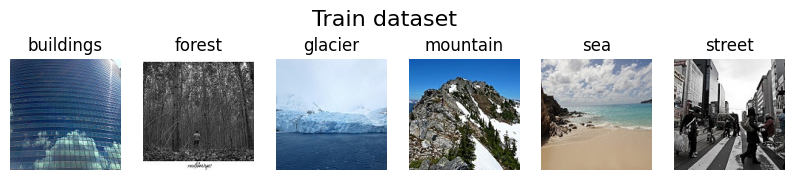

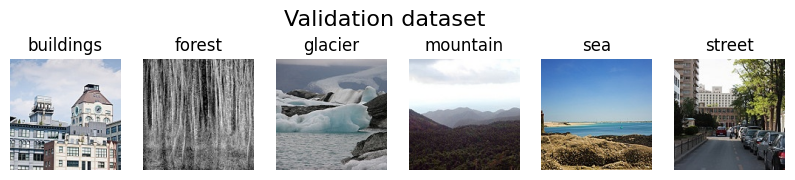

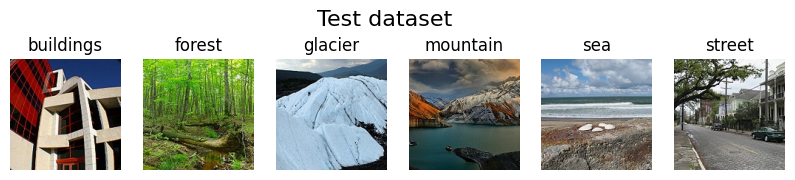

In [ ]:
display_random_images(train_directories, 'Train dataset')
display_random_images(validation_directories, 'Validation dataset')
display_random_images(test_directories, 'Test dataset')


The images above exhibit similarities among certain categories (e.g., street and buildings), which could make their accurate classification more challenging for our model.

The following functions are defined to illustrate the frequency distributions of categories for each of the three sets.

In [ ]:
def plot_category_frequencies(categories, train_directories, validation_directories, test_directories):
    train_frequencies = []
    validation_frequencies = []
    test_frequencies = []

    for category in categories:
        train_count = len(os.listdir(train_directories[categories.index(category)]))
        validation_count = len(os.listdir(validation_directories[categories.index(category)]))
        test_count = len(os.listdir(test_directories[categories.index(category)]))

        train_frequencies.append(train_count)
        validation_frequencies.append(validation_count)
        test_frequencies.append(test_count)

    return train_frequencies, validation_frequencies, test_frequencies

def plot_training_validation_test_category_frequencies(categories, train_directories, validation_directories, test_directories):
    train_frequencies, validation_frequencies, test_frequencies = plot_category_frequencies(categories, train_directories, validation_directories, test_directories)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    bar_width = 0.6
    index = range(len(categories))
    colors = ['sienna', 'darkgreen', 'paleturquoise', 'tan', 'steelblue', 'slategray']

    bars_train = axs[0].bar(index, train_frequencies, bar_width, label='Training',color = colors)
    bars_valid = axs[1].bar(index, validation_frequencies, bar_width, label='Validation',color = colors)
    bars_test  = axs[2].bar(index, test_frequencies, bar_width, label='Test',color = colors)

    axs[0].set_xlabel('Categories')
    axs[0].set_ylabel('Number of Images')
    axs[0].set_title('Frequencies of Categories in Training Dataset')
    axs[0].set_xticks(index)
    axs[0].set_xticklabels(categories)

    axs[1].set_xlabel('Categories')
    axs[1].set_ylabel('Number of Images')
    axs[1].set_title('Frequencies of Categories in Validation Dataset')
    axs[1].set_xticks(index)
    axs[1].set_xticklabels(categories)

    axs[2].set_xlabel('Categories')
    axs[2].set_ylabel('Number of Images')
    axs[2].set_title('Frequencies of Categories in Test Dataset')
    axs[2].set_xticks(index)
    axs[2].set_xticklabels(categories)

    for bar in bars_valid:
      yval = bar.get_height()
      axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

    for bar in bars_train:
      yval = bar.get_height()
      axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), ha='center', va='bottom')
    plt.tight_layout()

    for bar in bars_test:
      yval = bar.get_height()
      axs[2].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), ha='center', va='bottom')
    plt.tight_layout()

    plt.show()

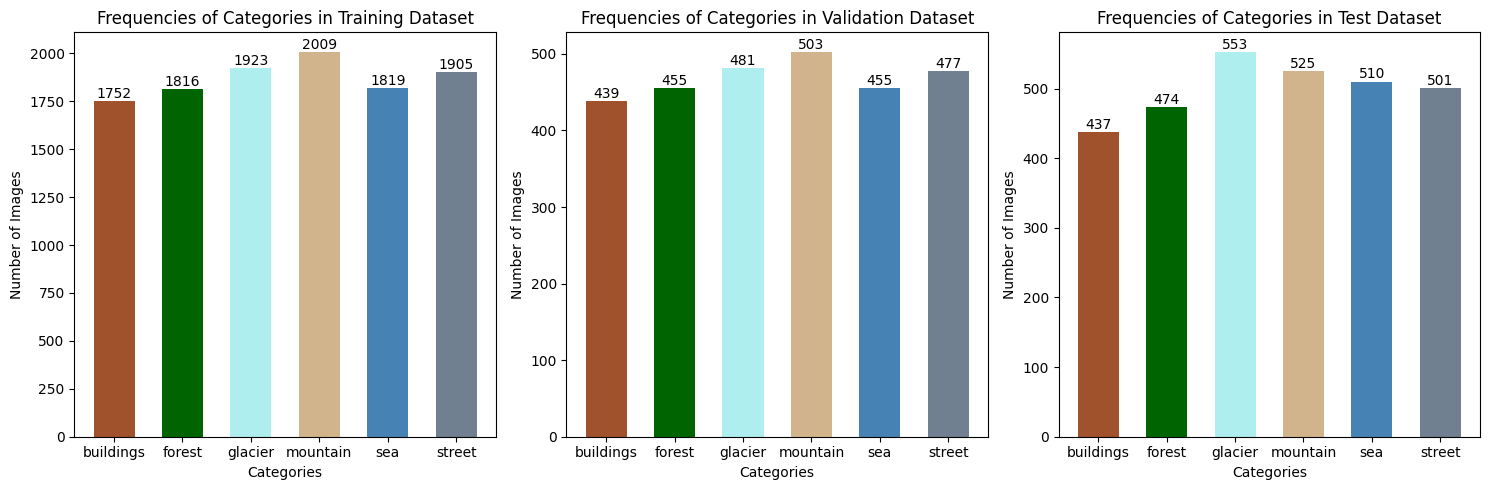

In [ ]:
plot_training_validation_test_category_frequencies(categories_l, train_directories, validation_directories, test_directories)

Examining the resulting plots, it is evident that the distribution of images is well-balanced across all categories within each set. Consequently, there is no need to make adjustments to the classes' size.

Since our dataset is made up of RGB images, we randomly choose an image from the *glacier*, *sea* and *mountain* categories to analyze the frequency distribution of pixels for each channel.

In [ ]:
def plot_image_and_histograms(image_path, position):
    image = Image.open(image_path)
    image_array = np.array(image)

    red_channel = image_array[:, :, 0].flatten()
    green_channel = image_array[:, :, 1].flatten()
    blue_channel = image_array[:, :, 2].flatten()

    plt.subplot(2, 3, position)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(2, 3, position + 3)
    plt.hist(red_channel, bins=256, range=(0, 256), color='red', alpha=0.5, label='Red')
    plt.hist(green_channel, bins=256, range=(0, 256), color='green', alpha=0.5, label='Green')
    plt.hist(blue_channel, bins=256, range=(0, 256), color='blue', alpha=0.5, label='Blue')
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()

In [ ]:
image_directories = ['/content/seg_train/seg_train/glacier', '/content/seg_train/seg_train/sea', '/content/seg_train/seg_train/mountain']

In [ ]:
random.seed(128)

random_image_filenames = []
for image_dir in image_directories:
  image_files = os.listdir(image_dir)
  random_image_filename = random.choice(image_files)
  random_image_filenames.append(random_image_filename)

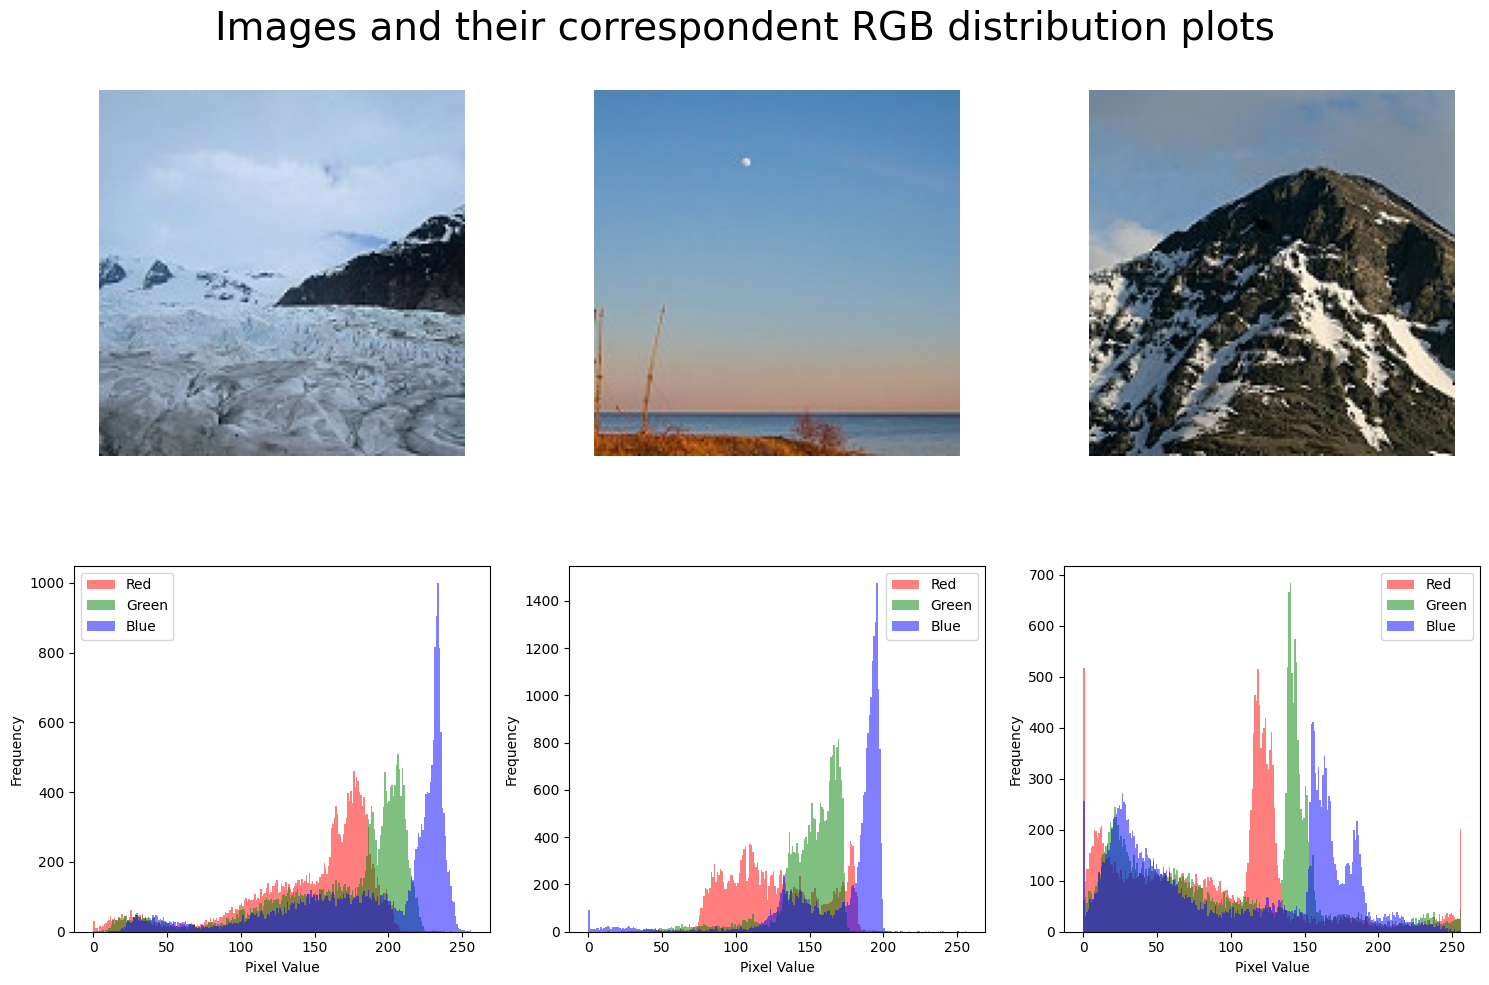

In [ ]:
plt.figure(figsize=(15, 10))

for i, image_filename in enumerate(random_image_filenames, start = 1):
    image_path = os.path.join(image_directories[i-1], image_filename)
    plot_image_and_histograms(image_path, i)

plt.tight_layout()
plt.suptitle('Images and their correspondent RGB distribution plots', fontsize = 28)
plt.subplots_adjust(top=0.9, hspace=0.3)
plt.show()

The x-axis represents the range of values (0, 255) that can be assumed by the pixels in an image, where 0 corresponds to black and 255 to white. Meanwhile, the vertical axis illustrates the frequency associated with each pixel value.

As expected, the first image sourced from the *glacier* directory displays a higher concentration of pixels with elevated values. Conversely, the third image showcases more pixels with lower values, indicative of darker colors.

## Data preparation


Before implementing the model, we need to preprocess the data to meet the model's requirements and facilitate its training. <br>
Since AlexNet model is designed for 224x224 images, we must resize our images and transform them in tensors. This transformation is essential as algorithms typically expect numerical features for processing.

In [ ]:
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.RandomCrop(224),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.RandomCrop(224),
                                     transforms.ToTensor()])

In [ ]:
train_path = '/content/seg_train/seg_train'
val_path = '/content/seg_train/seg_val'
test_path = '/content/seg_test/seg_test'

The *ImageFolder* class is used to load the Train, Validation and Test sets, where images are organised in categories, and to automatically assign labels to images based on folders names.

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=test_transform)

In [ ]:
def get_dataloader_workers():
    """Use as many processes working in parallel to read the data as # CPU cores"""
    import os
    return os.cpu_count()

After defining the batch size, we use the *DataLoader* class to organize the data in batches, enabling shuffling and utilizing multiple workers for efficient data loading.

In [ ]:
torch.manual_seed(22)

batch_size = 64
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = get_dataloader_workers())
val_dl = DataLoader(val_dataset, batch_size, shuffle = True, num_workers = get_dataloader_workers())
test_dl = DataLoader(test_dataset, batch_size, shuffle = True, num_workers = get_dataloader_workers())

Finally, we create iterators for the training, validation and test data loaders.

In [ ]:
train_iter = iter(train_dl)
val_iter = iter(val_dl)
test_iter = iter(test_dl)

# AlexNet

**AlexNet** is a type of **Convolutional Neural Network**, which is particularly good at understanding images and classification tasks. <br>
A CNN has three layers: a convolutional layer, a pooling layer, and a fully connected layer.

The first one is the main building block in a CNN and it applies to the input data convolutional operations, that involve sliding a filter (kernel) over the data. The filter is just a small matrix of weights and, at each position, element-wise multiplication is performed between the filter and the corresponding region of the input. The results are summed up to produce a single value for that position.

![](https://miro.medium.com/v2/resize:fit:2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

The above animation shows that the operation is repeated across the entire input, producing a feature map.

The pooling layer, instead, is responsible for downsampling the spatial dimensions of the input feature maps.

## Model architecture

The AlexNet has eight layers with learnable parameters. The architecture is structured with five convolutional layers, incorporating max pooling after the first, second, and fifth layers, followed by three fully connected layers. Rectified Linear Unit (ReLU) activation is applied in every layer, excluding the output one.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*IOvC3mgxzKBO502e.png)

In the following we define and implement a slightly modified version of the model, since the traditional approach did not achieve satisfying results. <br>
We incorporate in each convolutional layer batch normalization to avoid changes in the distributions of the inputs during the training phase. <br>
It works by normalizing the input of each layer across a batch, computing the mean and the standard deviation for each channel:

$$
y = \frac{x - E(x)}{\sqrt{Var(x)}} * \gamma + \beta
$$

where $\gamma$ and $\beta$ are learnable parameter vectors of size C, which is the input size. By default, the elements of $\gamma$ and $\beta$ are set to 1 and 0 respectively. <br>
Moreover, we add an average pooling after the central layers to further downsample the spacial dimension of feature maps. It differs from the max pooling approach because the former computes the average of the values for each pooling window, while the latter only selects the maximum value from the region. <br>
Finally we insert another fully connected layer with activation function ReLu.

The forward method defines the sequence of operations the input tensor undergoes as it passes through the neural network layers, from feature extraction to final classification.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 6)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

To measure the performance of our model we use the Cross Entropy Loss Function, which is especially used when the output of a model is a probability distribution over classes.

In [ ]:
model = AlexNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# compute the cross entropy loss between input logits and target
# it is useful when training a classification problem with C classes
# if provided, the optional argument weight should be a 1D tensor assigning weight to each of the classes
# this is particularly useful when you have an unbalanced training set
# the input is expected to have the unnormalized logits for each class
# it must be a tensor of size (minibatch, C) where C is the number of classes (ypred below)
# the target is expected to contain class indices in the range [0,C) (label below)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

The following code executes the training phase, which proceeds through either for 20 epochs or until the stopping rule is met: if the model does not exhibit improvement in validation loss for 5 consecutive epochs, training is halted. <br>
Within each epoch, after having been trained using forward and backward passes for every batch in the training set, the model is evaluated by iterating along the validation set, to assess its performance in dealing with unseen data.
Furthermore for each epoch we compute the training and validation loss and validation accuracy.


In [ ]:
torch.manual_seed(22)
random.seed(22)
np.random.seed(22)

total_batch = len(train_dl)
val_batch = len(val_dl)

epochs = 20
tot_loss_list = []
val_loss_list = []
acc_list = []

best_val_loss = float('inf')
patience = 5
no_improvement_count = 0

total_epochs = 0


for epoch in range(epochs):
    total_epochs += 1
    total_loss = 0

    # Training
    with tqdm(enumerate(train_dl), total=len(train_dl), desc=f'Epoch {epoch + 1} Training') as progress_bar:
        for num, data in progress_bar:
            image, label = data             # label is a tensor containing the true labels for the observations of the considered batch
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()           # reset the optimizer
            ypred = model.forward(image)    # matrix (minibatch, 6) where each column contains a value for each class and each row represents an observation
            loss = loss_fn(ypred, label)    # compute the loss function (single value for each batch)
            total_loss += loss

            loss.backward()                 # backward propagation, it uses DAG and chain rule
                                            # computes the gradient of current tensor wrt graph leaves
            optimizer.step()                # perform a single optimization step (parameter update)

            progress_bar.set_postfix(loss=f'{loss.item():.4f}', refresh=True)

    # compute the average loss per batch by dividing the total loss by the total number of batches
    # detach the result from the computation graph; used when you do not need to backpropagate through this operation
    # move the tensor from any available GPU to CPU
    # convert the PyTorch tensor into a NumPy array
    tot_loss_list.append((total_loss / total_batch).detach().cpu().numpy())
    print(f'Epochs: {epoch+1} Training Loss: {total_loss / total_batch}')

    # context manager that disables gradient calculation, useful for inference
    # reduce memory consumption for computations that would otherwise have requires_grad = True
    with torch.no_grad():
        val_loss = 0
        total_correct = 0
        total_samples = 0

        # Validation
        with tqdm(enumerate(val_dl), total=len(val_dl), desc=f'Epoch {epoch + 1} Validation') as val_progress_bar:
            for num, data in val_progress_bar:
                val_image, val_label = data
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_out = model.forward(val_image)
                v_loss = loss_fn(val_out, val_label)
                val_loss += v_loss

                # returns a namedtuple (values, indices) where values is the maximum value of each row
                # of the input tensor in the given dimension dim, and indices is the index location
                # of each maximum value found (argmax)
                _, predicted = torch.max(val_out, 1)
                # perform element-wise comparison between the predicted values and the ground truth labels,
                # resulting in a Boolean tensor where each element is 'True' if the prediction is correct,
                # and 'False' otherwise
                # sum calculates the total number of correct predictions by summing up the 'True' values
                # item converts the total number of correct predictions (which is a 0-dimensional tensor)
                # to an integer and adds it to the running total
                # total_correct accumulates the total number of correct predictions across multiple batches
                total_correct += (predicted == val_label).sum().item()
                # retrieve the size of the first dimension of the val_label tensor, which corresponds to the number of samples in the batch
                total_samples += val_label.size(0)

                val_progress_bar.set_postfix(loss=f'{v_loss.item():.4f}', refresh=True)

        accuracy_val = total_correct / total_samples
        acc_list.append(accuracy_val)

        val_loss_avg = val_loss / val_batch
        val_loss_list.append(val_loss_avg.detach().cpu().numpy())
        print(f'Epoch {epoch + 1} Validation Loss: {val_loss / val_batch}')
        print(f'Epoch {epoch + 1} Validation Accuracy: {accuracy_val}')
        print("-" * 50)

        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch + 1} as there is no improvement in validation loss.')
            break


print("Training Finished")

Epoch 1 Training: 100%|██████████| 176/176 [00:36<00:00,  4.79it/s, loss=1.9260]

Epochs: 1 Training Loss: 1.4980807304382324



Epoch 1 Validation: 100%|██████████| 44/44 [00:05<00:00,  7.39it/s, loss=1.1684]

Epoch 1 Validation Loss: 1.13929283618927
Epoch 1 Validation Accuracy: 0.5170818505338078
--------------------------------------------------



Epoch 2 Training: 100%|██████████| 176/176 [00:28<00:00,  6.23it/s, loss=1.6608]

Epochs: 2 Training Loss: 1.0922622680664062



Epoch 2 Validation: 100%|██████████| 44/44 [00:06<00:00,  6.56it/s, loss=1.0869]

Epoch 2 Validation Loss: 1.1400588750839233
Epoch 2 Validation Accuracy: 0.5782918149466192
--------------------------------------------------



Epoch 3 Training: 100%|██████████| 176/176 [00:26<00:00,  6.55it/s, loss=1.3339]

Epochs: 3 Training Loss: 1.0375665426254272



Epoch 3 Validation: 100%|██████████| 44/44 [00:07<00:00,  5.74it/s, loss=1.0561]

Epoch 3 Validation Loss: 0.9332032799720764
Epoch 3 Validation Accuracy: 0.6338078291814947
--------------------------------------------------



Epoch 4 Training: 100%|██████████| 176/176 [00:26<00:00,  6.69it/s, loss=0.9347]

Epochs: 4 Training Loss: 0.963688850402832



Epoch 4 Validation: 100%|██████████| 44/44 [00:08<00:00,  5.29it/s, loss=1.1112]

Epoch 4 Validation Loss: 0.9346449971199036
Epoch 4 Validation Accuracy: 0.6555160142348755
--------------------------------------------------



Epoch 5 Training: 100%|██████████| 176/176 [00:26<00:00,  6.67it/s, loss=0.4394]

Epochs: 5 Training Loss: 0.8895352482795715



Epoch 5 Validation: 100%|██████████| 44/44 [00:08<00:00,  5.50it/s, loss=0.9076]

Epoch 5 Validation Loss: 0.8668193817138672
Epoch 5 Validation Accuracy: 0.7046263345195729
--------------------------------------------------



Epoch 6 Training: 100%|██████████| 176/176 [00:26<00:00,  6.56it/s, loss=0.7763]

Epochs: 6 Training Loss: 0.8249946236610413



Epoch 6 Validation: 100%|██████████| 44/44 [00:07<00:00,  6.08it/s, loss=0.6910]

Epoch 6 Validation Loss: 0.7911074757575989
Epoch 6 Validation Accuracy: 0.7131672597864769
--------------------------------------------------



Epoch 7 Training: 100%|██████████| 176/176 [00:27<00:00,  6.36it/s, loss=1.3598]

Epochs: 7 Training Loss: 0.7742211222648621



Epoch 7 Validation: 100%|██████████| 44/44 [00:06<00:00,  6.70it/s, loss=1.4147]

Epoch 7 Validation Loss: 0.7935389876365662
Epoch 7 Validation Accuracy: 0.7466192170818505
--------------------------------------------------



Epoch 8 Training: 100%|██████████| 176/176 [00:28<00:00,  6.26it/s, loss=1.2666]

Epochs: 8 Training Loss: 0.7164652943611145



Epoch 8 Validation: 100%|██████████| 44/44 [00:05<00:00,  7.80it/s, loss=0.5808]

Epoch 8 Validation Loss: 0.6729806065559387
Epoch 8 Validation Accuracy: 0.7722419928825622
--------------------------------------------------



Epoch 9 Training: 100%|██████████| 176/176 [00:29<00:00,  6.03it/s, loss=0.3871]

Epochs: 9 Training Loss: 0.6910425424575806



Epoch 9 Validation: 100%|██████████| 44/44 [00:05<00:00,  8.26it/s, loss=0.6343]

Epoch 9 Validation Loss: 0.7036932706832886
Epoch 9 Validation Accuracy: 0.7807829181494662
--------------------------------------------------



Epoch 10 Training: 100%|██████████| 176/176 [00:29<00:00,  5.93it/s, loss=0.2418]

Epochs: 10 Training Loss: 0.6311399340629578



Epoch 10 Validation: 100%|██████████| 44/44 [00:05<00:00,  8.08it/s, loss=0.5519]

Epoch 10 Validation Loss: 0.6290116310119629
Epoch 10 Validation Accuracy: 0.799288256227758
--------------------------------------------------



Epoch 11 Training: 100%|██████████| 176/176 [00:29<00:00,  6.00it/s, loss=0.9468]

Epochs: 11 Training Loss: 0.5876625180244446



Epoch 11 Validation: 100%|██████████| 44/44 [00:05<00:00,  8.11it/s, loss=0.6091]

Epoch 11 Validation Loss: 0.6494053602218628
Epoch 11 Validation Accuracy: 0.7925266903914591
--------------------------------------------------



Epoch 12 Training: 100%|██████████| 176/176 [00:29<00:00,  5.97it/s, loss=0.6479]

Epochs: 12 Training Loss: 0.5622099041938782



Epoch 12 Validation: 100%|██████████| 44/44 [00:05<00:00,  8.08it/s, loss=0.5553]

Epoch 12 Validation Loss: 0.6526589393615723
Epoch 12 Validation Accuracy: 0.7925266903914591
--------------------------------------------------



Epoch 13 Training: 100%|██████████| 176/176 [00:28<00:00,  6.12it/s, loss=0.4058]

Epochs: 13 Training Loss: 0.535929262638092



Epoch 13 Validation: 100%|██████████| 44/44 [00:06<00:00,  7.25it/s, loss=0.6425]

Epoch 13 Validation Loss: 0.608501136302948
Epoch 13 Validation Accuracy: 0.80711743772242
--------------------------------------------------



Epoch 14 Training: 100%|██████████| 176/176 [00:28<00:00,  6.19it/s, loss=0.6074]

Epochs: 14 Training Loss: 0.49843621253967285



Epoch 14 Validation: 100%|██████████| 44/44 [00:06<00:00,  6.68it/s, loss=0.7854]

Epoch 14 Validation Loss: 0.5982116460800171
Epoch 14 Validation Accuracy: 0.8145907473309608
--------------------------------------------------



Epoch 15 Training: 100%|██████████| 176/176 [00:27<00:00,  6.30it/s, loss=0.3582]

Epochs: 15 Training Loss: 0.4919261932373047



Epoch 15 Validation: 100%|██████████| 44/44 [00:07<00:00,  6.14it/s, loss=0.9372]

Epoch 15 Validation Loss: 0.598608136177063
Epoch 15 Validation Accuracy: 0.8088967971530249
--------------------------------------------------



Epoch 16 Training: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s, loss=0.5714]

Epochs: 16 Training Loss: 0.464096337556839



Epoch 16 Validation: 100%|██████████| 44/44 [00:08<00:00,  5.35it/s, loss=0.4898]

Epoch 16 Validation Loss: 0.5497339367866516
Epoch 16 Validation Accuracy: 0.8277580071174377
--------------------------------------------------



Epoch 17 Training: 100%|██████████| 176/176 [00:26<00:00,  6.62it/s, loss=0.7115]

Epochs: 17 Training Loss: 0.45414671301841736



Epoch 17 Validation: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s, loss=0.4081]

Epoch 17 Validation Loss: 0.5722867250442505
Epoch 17 Validation Accuracy: 0.8170818505338078
--------------------------------------------------



Epoch 18 Training: 100%|██████████| 176/176 [00:26<00:00,  6.69it/s, loss=0.4323]

Epochs: 18 Training Loss: 0.4369601011276245



Epoch 18 Validation: 100%|██████████| 44/44 [00:07<00:00,  5.53it/s, loss=0.5400]

Epoch 18 Validation Loss: 0.5477226376533508
Epoch 18 Validation Accuracy: 0.8174377224199288
--------------------------------------------------



Epoch 19 Training: 100%|██████████| 176/176 [00:27<00:00,  6.47it/s, loss=0.4100]

Epochs: 19 Training Loss: 0.42321890592575073



Epoch 19 Validation: 100%|██████████| 44/44 [00:07<00:00,  6.13it/s, loss=0.6613]

Epoch 19 Validation Loss: 0.5745267868041992
Epoch 19 Validation Accuracy: 0.8209964412811388
--------------------------------------------------



Epoch 20 Training: 100%|██████████| 176/176 [00:27<00:00,  6.30it/s, loss=0.3881]

Epochs: 20 Training Loss: 0.4026556611061096



Epoch 20 Validation: 100%|██████████| 44/44 [00:06<00:00,  6.97it/s, loss=0.4236]

Epoch 20 Validation Loss: 0.514153778553009
Epoch 20 Validation Accuracy: 0.8334519572953737
--------------------------------------------------
Training Finished


Here follow two graphs representing the performance of our model along epochs.

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

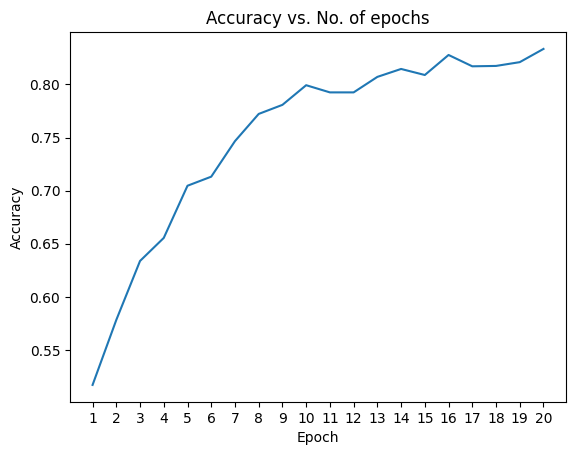

In [ ]:
plt.plot([i for i in range(1,total_epochs+1)], [j for j in acc_list])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, total_epochs+1))
plt.title('Accuracy vs. No. of epochs')

Text(0.5, 1.0, 'Validation and train loss vs. No. of epochs')

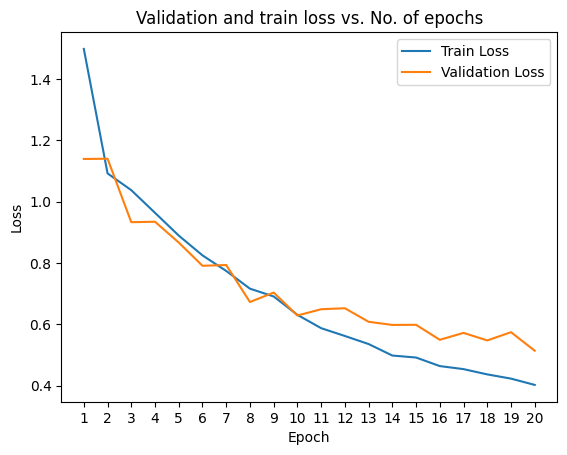

In [ ]:
plt.plot([i for i in range(1,total_epochs+1)], [j for j in tot_loss_list], label = "Train Loss")
plt.plot([i for i in range(1,total_epochs+1)], [j for j in val_loss_list], label = "Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, total_epochs+1))
plt.title('Validation and train loss vs. No. of epochs')

## Testing data

After the training phase, the model is used to classify unseen images from the test set.

In [ ]:
pred = []
Y = []
for i, (x,y) in enumerate(test_dl):
    with torch.no_grad():
        x = x.to(device)
        outputs = model(x)            # compute the prediction
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       437
           1       0.93      0.96      0.95       474
           2       0.87      0.73      0.79       553
           3       0.81      0.83      0.82       525
           4       0.79      0.90      0.84       510
           5       0.82      0.90      0.86       501

    accuracy                           0.84      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



The model's performance can be evaluated by looking at some indicators, such as the accuracy and the F1-score, that both reach the 84%, revealing a quite strong ability in
recognizing landscapes.

In [ ]:
categories = set()
categories.add('buildings')
categories.add('forest')
categories.add('glacier')
categories.add('mountain')
categories.add('sea')
categories.add('street')

In [ ]:
def plot_confusion_matrix(y_preds, y_test, labels):
    cm = confusion_matrix(y_test, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="BuPu", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

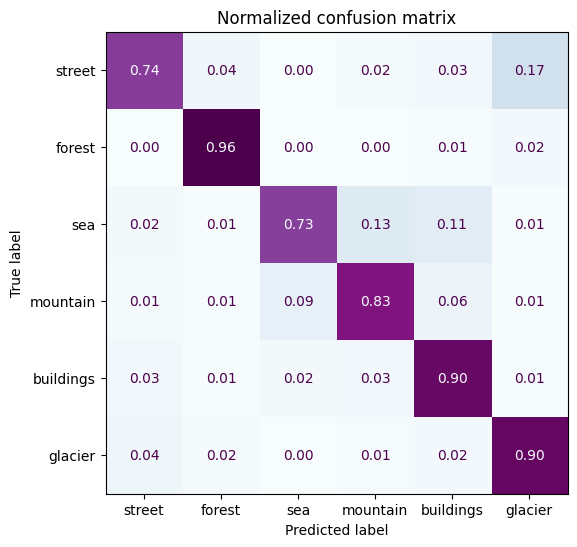

In [ ]:
plot_confusion_matrix(pred, Y, categories)

The confusion matrix shows that the model performs quite well, as previously highlighted. Nonetheless, it encounters some minor challenges in classifying images representing streets and seas.

By the way of example, we illustrate the images within a batch along with their corresponding correct and predicted labels.

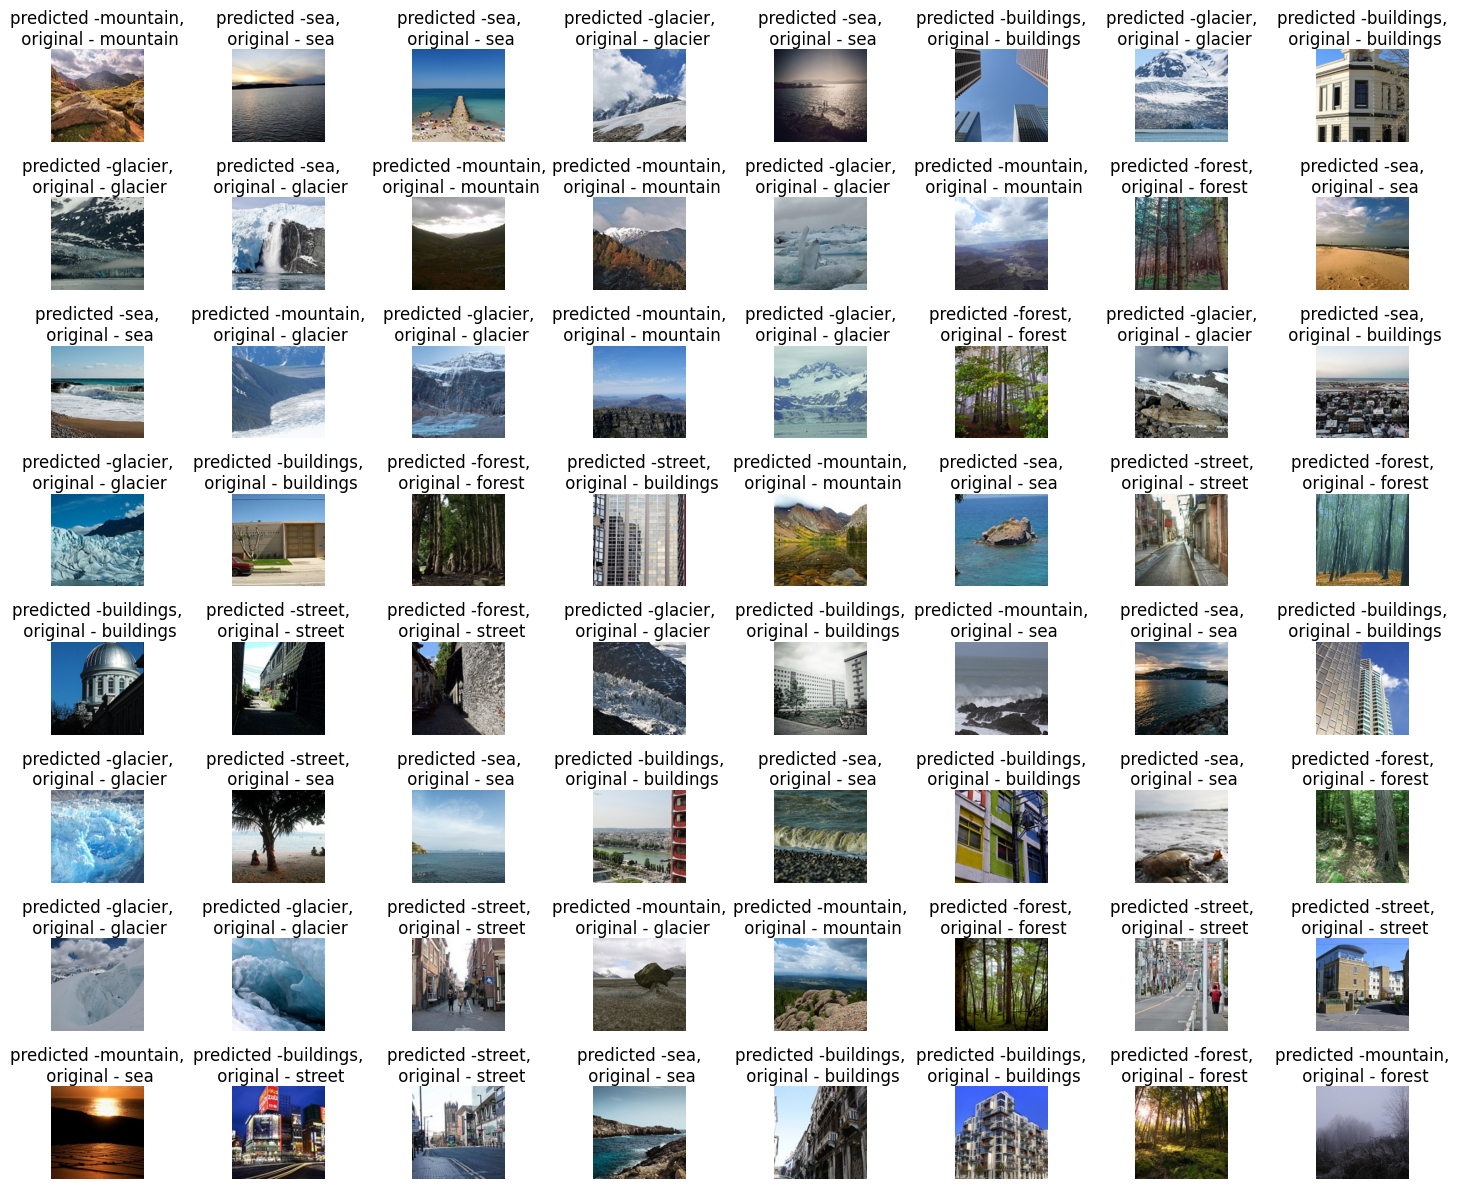

In [ ]:
samples, labels = next(test_iter)
samples = samples.to(device)
output = model.forward(samples)

pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
cat ={
    0: 'buildings', 1: 'forest', 2: 'glacier', 3 : 'mountain', 4: "sea",
    5: 'street'
}

fig = plt.figure(figsize=(15, 12))
fig.tight_layout()

for num, sample in enumerate(samples):
    plt.subplot(8,8,num+1)
    plt.title(f'predicted -{cat[pred[num]]},\n original - {cat[int(labels[num])]}',loc='center', wrap=True)
    plt.axis('off')
    plt.tight_layout()
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))
